In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

You will be using the eponymously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, you'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 


# Content Cost

#### Make Generated Image G Match the Content of Image C

One goal you should aim for when performing NST is for the content in generated image G to match the content of image C. To do so, you'll need an understanding of <b> shallow versus deep layers </b>:

* The shallower layers of a ConvNet tend to detect lower-level features such as <i>edges and simple textures</i>.
* The deeper layers tend to detect higher-level features such as more <i> complex textures and object classes</i>. 

#### To choose a "middle" activation layer $a^{[l]}$ :
You need the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you will usually get the most visually pleasing results if you choose a layer from somewhere in the middle of the network--neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.
* After you have finished this exercise, feel free to come back and experiment with using different layers to see how the results vary!


One goal you should aim for when performing NST is for the content in generated image G to match the content of image C. A method to achieve this is to calculate the content cost function, which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style cost $J_{style}$.

<div style="text-align: center;">
    <img src="images/NST_LOSS.png" style="width:800px;height:400px;">
</di>


In [2]:
def compute_content_cost(content_layer, generated_layer):
    """
    Computes the content cost between the content and generated images.

    Arguments:
    content_layer -- tensor of shape (1, n_H, n_W, n_C), activations from a specific layer of the content image
    generated_layer -- tensor of shape (1, n_H, n_W, n_C), activations from the same layer of the generated image

    Returns:
    J_content -- scalar, the content cost computed as the squared difference between the activations of the content and generated images
    """
    
    m, n_H, n_W, n_C = content_layer.shape

    # Permutes the dimensions from (m, n_H, n_W, n_C) to (m, n_C, n_H, n_W)
    cl_transposed = tf.transpose(content_layer, perm=[0, 3, 1, 2])
    gl_transposed = tf.transpose(generated_layer, perm=[0, 3, 1, 2])

    cl_unrolled = tf.reshape(cl_transposed, [n_C, n_H*n_W])
    gl_unrolled = tf.reshape(gl_transposed, [n_C, n_H*n_W])

    J_content = tf.square(tf.subtract(cl_unrolled - gl_unrolled))
    J_content = tf.reduce_sum(J_content) / (4 * n_H * n_W * n_C)
    return J_content

# Style Cost

You will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

<div style="text-align: center;">
    <img src="images/NST_GM.png" style="width:800px;height:300px;">
</div>

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

In [3]:
def gram_maxtrix(unrolled_layer):
    """
    Computes the Gram matrix for a given unrolled layer.

    The Gram matrix captures the style by calculating correlations between filter activations in a specific layer.

    Arguments:
    unrolled_layer -- tensor of shape (n_C, n_H * n_W), the unrolled feature maps of a layer (after reshaping)

    Returns:
    matrix -- tensor of shape (n_C, n_C), the Gram matrix capturing correlations between channels
    """

    matrix = tf.matmul(unrolled_layer, tf.transpose(unrolled_layer))
    return matrix

You now know how to calculate the Gram matrix. Congrats! Your next goal will be to minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G. 
* For now, you will use only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Make sure you remember that this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$

In [4]:
def compute_style_cost_each_layer(style_layer, generated_layer):
    """
    Computes the style cost between the content and generated images.

    This is done by comparing the Gram matrices of the content and generated images, which capture correlations between feature maps, representing the style of the image.

    Arguments:
    style_layer -- tensor of shape (1, n_H, n_W, n_C), activations from a specific layer of the style image
    generated_layer -- tensor of shape (1, n_H, n_W, n_C), activations from the same layer of the generated image

    Returns:
    J_style -- scalar, the style cost computed as the squared difference between the Gram matrices of the style and generated images
    """
    m, n_H, n_W, n_C = style_layer.shape

    # Permutes the dimensions from (m, n_H, n_W, n_C) to (m, n_C, n_H, n_W)
    sl_transposed = tf.transpose(style_layer, perm=[0, 3, 1, 2])
    gl_transposed = tf.transpose(generated_layer, perm=[0, 3, 1, 2])

    sl_unrolled = tf.reshape(sl_transposed, [n_C, n_H*n_W])
    gl_unrolled = tf.reshape(gl_transposed, [n_C, n_H*n_W])

    sl_matrix = gram_maxtrix(sl_unrolled)  # (n_C, n_C)
    gl_matrix = gram_maxtrix(gl_unrolled)

    J_style = tf.square(tf.subtract(sl_matrix - gl_matrix))
    J_style = tf.reduce_sum(J_style) / (4 * n_H**2 * n_W**2 * n_C**2)
    return J_content

#### Style Weights

* So far you have captured the style from only one layer. 
* You'll get better results if you "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$.
* By default, give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given.


How do you choose the coefficients for each layer? The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if you want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if you want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers.


In [5]:
def compute_style_cost(style_layers, generated_layers, weights):
    style_layers = style_layers[:-1]  # The last element of the array contains the content layer, which must not be used.
    generated_layers = generated_layers[:-1]

    J_style = 0
    for i, (_, weight) in enumerate(weights):
        J_style_each_layer = compute_style_cost_each_layer(style_layers[i], generated_layers[i])
        J_style += weight * J_style_each_layer

    return J_style

# Total Cost

Finally, you will create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [6]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

# Data

### Content Image

In [7]:
IMAGE_SIZE = IMAGE_SIZE = (400, 400)

TensorShape([1, 400, 400, 3])

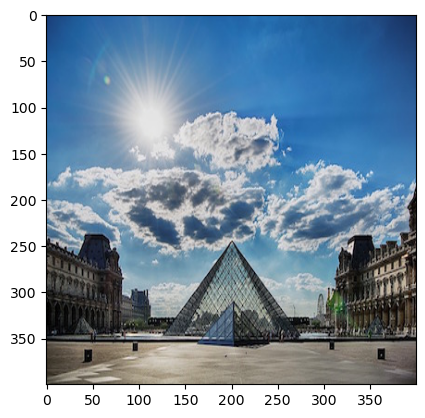

In [8]:
content_path = 'images/louvre_small.jpg'
content_img = Image.open(content_path).resize(IMAGE_SIZE)  # image

content_arr = np.array(content_img)  # converts image to an array (n_H, n_W, n_C)
content_arr = content_arr[np.newaxis, ...]  # (1, n_H, n_W, n_C)

content_tensor = tf.constant(content_arr)

plt.imshow(content_tensor[0])
content_tensor.shape

### Style Image

TensorShape([1, 400, 400, 3])

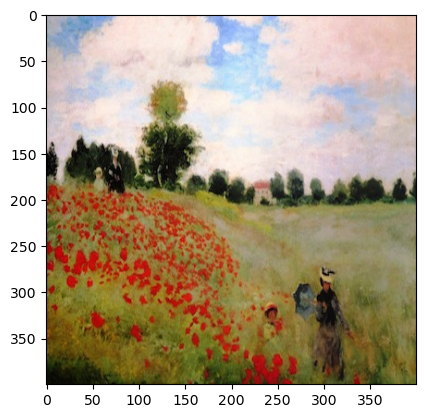

In [9]:
style_path = 'images/monet.jpg'
style_img = Image.open(style_path).resize(IMAGE_SIZE)

style_arr = np.array(style_img)
style_arr = style_arr[np.newaxis, ...]

style_tensor = tf.constant(style_arr)

plt.imshow(style_tensor[0])
style_tensor.shape

### Generated Image

TensorShape([1, 400, 400, 3])

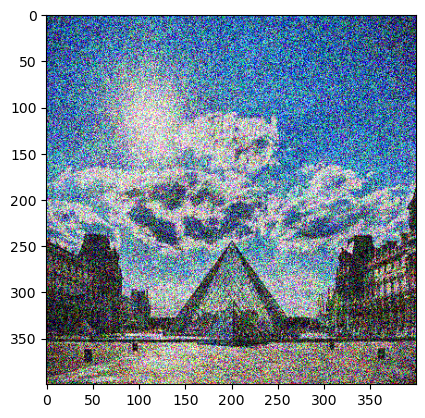

In [10]:
generated_tensor = tf.Variable(tf.image.convert_image_dtype(content_tensor, tf.float32))
noise = tf.random.uniform(shape=generated_tensor.shape, minval=-0.5, maxval=0.5)

generated_tensor = tf.add(generated_tensor, noise)
generated_tensor = tf.clip_by_value(generated_tensor, clip_value_min=0.0, clip_value_max=1.0)

plt.imshow(generated_tensor[0])
generated_tensor.shape

# Base Model

In [11]:
INPUT_SHAPE = IMAGE_SIZE + (3, )

In [12]:
vgg19 = keras.applications.VGG19(input_shape=INPUT_SHAPE, include_top=False)
vgg19.trainable = False

In [13]:
vgg19.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 400, 400, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 400, 400, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 400, 400, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 200, 200, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 200, 200, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 200, 200, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 100, 100, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 100, 100, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 100, 100, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 100, 100, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 100, 100, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 50, 50, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 50, 50, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 50, 50, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 50, 50, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 50, 50, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 25, 25, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [14]:
vgg19.input

<KerasTensor shape=(None, 400, 400, 3), dtype=float32, sparse=None, name=keras_tensor>

In [15]:
vgg19.get_layer('block5_conv4').output

<KerasTensor shape=(None, 25, 25, 512), dtype=float32, sparse=False, name=keras_tensor_20>

In [16]:
def get_layer_outputs(model, output_layers):
    input = model.input
    outputs = [model.get_layer(layer_name).output for layer_name, _ in output_layers]

    model = keras.models.Model(input, outputs)
    return model

In [17]:
style_layers = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]

content_layer = [('block5_conv2', 1)]

output_layers = style_layers + content_layer

In [18]:
model = get_layer_outputs(vgg19, output_layers)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 400, 400, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 400, 400, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 400, 400, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 200, 200, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 200, 200, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 200, 200, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 100, 100, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 100, 100, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 100, 100, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 100, 100, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 100, 100, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 50, 50, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 50, 50, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 50, 50, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 50, 50, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 50, 50, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 25, 25, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,304,768 (58.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,304,768 (58.38 MB)